In [10]:
# coding: utf-8
import time
from PIL import Image
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader,  random_split
from torchvision import transforms
from torchvision import models
from torchvision.models import ResNet152_Weights
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda:0


In [12]:
get_label = lambda x: x.name.split('.')[0]


class get_dataset(Dataset):
    def __init__(self, root, transform=None):
        self.images = list(Path(root).glob('*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = get_label(img)
        label = 1 if label == 'dog' else 0
        if self.transform:
            img = self.transform(Image.open(img))
        return img, torch.tensor(label, dtype=torch.int64)

In [13]:
transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # resize the input image to a uniform size
    transforms.ToTensor(),  # convert PIL Image or numpy.ndarray to tensor and normalize to somewhere between [0,1]
    transforms.Normalize(   # standardized processing
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [14]:
train_path = './kaggle/inputs/train'
# get dataset
dataset = get_dataset(train_path, transform=transforms)
# splitting into train and validation
train_data, valid_data = random_split(
    dataset,
    lengths=[int(len(dataset) * 0.5),
             int(len(dataset) * 0.5)],
    generator=torch.Generator().manual_seed(7))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

# set config
feature_extract = True
num_epochs = 20

In [15]:
class ResNet(nn.Module):
    def __init__(self, num_classes, feature_extract):
        super(ResNet, self).__init__()
        self.resnet = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        if feature_extract:
            for param in self.resnet.parameters():
                param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(nn.Linear(num_features, num_classes),
                                       nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.resnet(x)
        return x

In [16]:
model = ResNet(2, feature_extract)
# train parameters
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

Params to learn:
	 resnet.fc.0.weight
	 resnet.fc.0.bias


In [22]:
model = model.to(device)
# set optimizer
optimizer = optim.Adam(params_to_update, lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7,
                                      gamma=0.1)
criterion = nn.NLLLoss()

In [23]:
# start training
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    since = time.time()
    t_loss, t_acc = 0.0, 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, 1)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item() * inputs.size(0)
        t_acc += torch.sum(preds == labels)

    time_elapsed = time.time() - since
    print('Time elapsed {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(t_loss / len(train_loader.dataset),
                                                  t_acc / len(train_loader.dataset)))

Epoch 1/20
Time elapsed 0m 12s
Train Loss: 0.0030 Acc: 0.9980
Epoch 2/20
Time elapsed 0m 11s
Train Loss: 0.0343 Acc: 0.9940
Epoch 3/20
Time elapsed 0m 11s
Train Loss: 0.0011 Acc: 1.0000
Epoch 4/20
Time elapsed 0m 11s
Train Loss: 0.0094 Acc: 0.9960
Epoch 5/20
Time elapsed 0m 11s
Train Loss: 0.0122 Acc: 0.9960
Epoch 6/20
Time elapsed 0m 11s
Train Loss: 0.0010 Acc: 1.0000
Epoch 7/20
Time elapsed 0m 12s
Train Loss: 0.0037 Acc: 0.9990
Epoch 8/20
Time elapsed 0m 12s
Train Loss: 0.0005 Acc: 1.0000
Epoch 9/20
Time elapsed 0m 12s
Train Loss: 0.0006 Acc: 1.0000
Epoch 10/20
Time elapsed 0m 12s
Train Loss: 0.0023 Acc: 0.9990
Epoch 11/20
Time elapsed 0m 11s
Train Loss: 0.0007 Acc: 1.0000
Epoch 12/20
Time elapsed 0m 11s
Train Loss: 0.0004 Acc: 1.0000
Epoch 13/20
Time elapsed 0m 12s
Train Loss: 0.0005 Acc: 1.0000
Epoch 14/20
Time elapsed 0m 12s
Train Loss: 0.0114 Acc: 0.9980
Epoch 15/20
Time elapsed 0m 12s
Train Loss: 0.0071 Acc: 0.9980
Epoch 16/20
Time elapsed 0m 12s
Train Loss: 0.0018 Acc: 0.9990
E

In [24]:
# start valid
v_loss, v_acc = 0.0, 0.0
since = time.time()
model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, 1)[1]

        v_loss += loss.item() * inputs.size(0)
        v_acc += torch.sum(preds == labels)

    time_elapsed = time.time() - since
    print('Time elapsed {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
    print('Valid Loss: {:.4f} Acc: {:.4f}'.format(v_loss / len(valid_loader.dataset),
                                                    v_acc / len(valid_loader.dataset)))

Time elapsed 0m 12s
Valid Loss: 0.0697 Acc: 0.9880


In [25]:
# start testing
test_path = './kaggle/inputs/test'
# get dataset
test_dataset = get_dataset(test_path, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=32)
_loss, _acc = 0.0, 0.0
since = time.time()
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, 1)[1]

        _loss += loss.item() * inputs.size(0)
        _acc += torch.sum(preds == labels)

    time_elapsed = time.time() - since
    print('Time elapsed {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(_loss / len(test_loader.dataset),
                                                    _acc / len(test_loader.dataset)))

Time elapsed 0m 5s
Test Loss: 0.0988 Acc: 0.9800


In [27]:
def im_convert(image):
    # color channel reduction
    image = np.array(image).transpose(1, 2, 0)
    # pretreatment reduction
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)

    return image

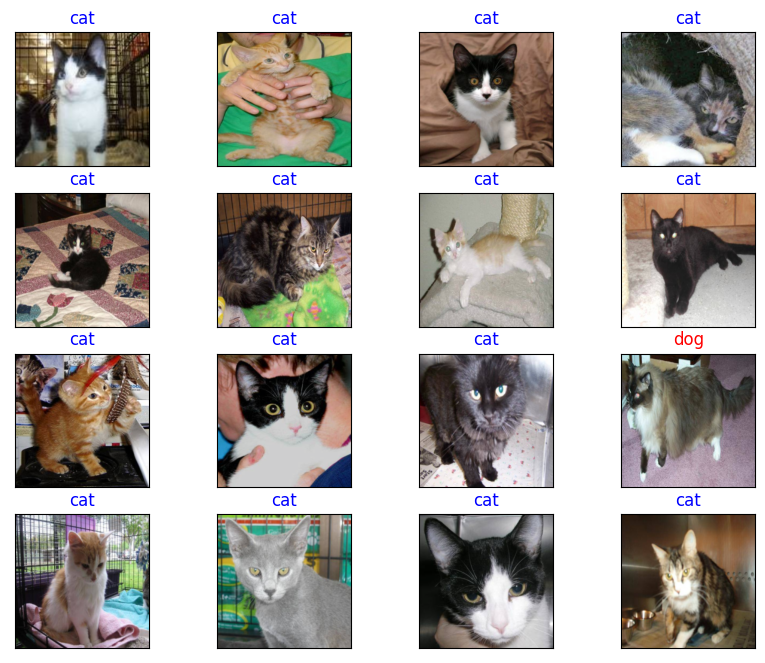

In [28]:
dataiter = iter((test_loader))
fig = plt.figure(figsize=(10, 8))
images, labels = next(dataiter)
model.eval()
output = model(images.cuda())
pred = torch.max(output, 1)[-1]

for idx in range(4 * 4):
    ax = plt.subplot(4, 4, idx + 1, xticks=[], yticks=[])
    ax.set_title('dog' if pred[idx] == 1 else 'cat', color=('blue' if pred[idx] == labels[idx] else 'red'))
    plt.imshow(im_convert(images[idx]))

plt.show()